# Семинар 13

RNN

Д.В. Яценко, по мотивам [семинара](https://in.harbour.space/data-science/deep-learning-in-applications-radoslav-neychev-anastasia-ianina/)

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear,Embedding,Sequential,ReLU,Dropout,BatchNorm1d,CrossEntropyLoss,Sigmoid
from torch.optim import Adam,RMSprop
from torch.autograd import Variable
import numpy as np
from random import sample
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from IPython.display import clear_output
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
BATCH_SIZE=1024

## Затухание градиента

In [35]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

In [4]:
print(train_source['data'][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [5]:
def rm_head(src):
    data=[]
    for t in src:
        if len(t.split("Lines:"))==2:
            data.append(t.split("Lines:")[1][4:])
        elif len(t.split("Organization:"))==2:
            data.append(t.split("Organization:")[1])
        else: data.append(t)
    return data    
train_source['data']=rm_head(train_source['data']) 
test_source['data']=rm_head(test_source['data'])     

In [6]:
train_source['data'][0]

'\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n'

In [7]:
TOKEN_RE = re.compile(r'[\w\d]+')
def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]
def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

In [8]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

In [9]:
from gensim.models import Word2Vec
vec = Word2Vec(train_tokenized,vector_size=32,min_count=5,window=5).wv

In [10]:
word_set=[]
vec_texts=np.zeros(32)
for text in train_tokenized:
    vec_text=np.zeros(32)
    for word in text:
        if word in vec:
            vec_text+=vec[word]
            word_set.append(word)        
    vec_texts=np.vstack((vec_texts,vec_text))
vec_texts=np.delete(vec_texts,0,axis=0)
word_set=set(word_set)
UNIQUE_WORDS_N=len(word_set)

In [11]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# model = Sequential(Linear(32,32),BatchNorm1d(32),Sigmoid(),Linear(32, 32),BatchNorm1d(32),Sigmoid(), Linear(32, 32),BatchNorm1d(32),Sigmoid(), Linear(32, 32),BatchNorm1d(32),Sigmoid(), Linear(32,len(set(train_source['target']))) ).to(device)
model = Sequential(Linear(32,32),BatchNorm1d(32),ReLU(),Linear(32, 32),BatchNorm1d(32),ReLU(), Linear(32, 32),BatchNorm1d(32),ReLU(), Linear(32, 32),BatchNorm1d(32),ReLU(), Linear(32,len(set(train_source['target']))) ).to(device)
BATCH=len(vec_texts)//200
optim=RMSprop(model.parameters(), lr=0.001)
shed=torch.optim.lr_scheduler.ReduceLROnPlateau(optim,patience=35)
loss=CrossEntropyLoss()

In [12]:
targets=torch.tensor(train_source['target'])
vec_texts=torch.tensor(vec_texts,dtype=torch.float)

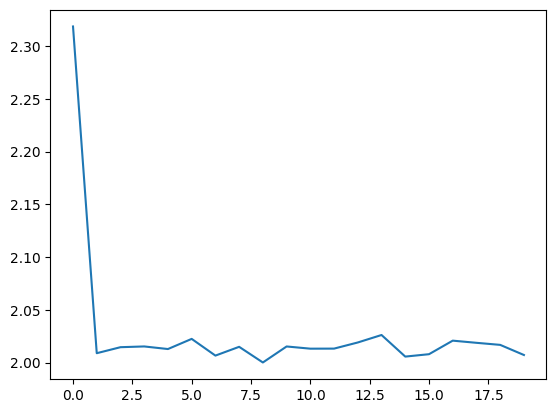

tensor(2.0540, device='cuda:1')

In [13]:
hist_loss=[]
for e in range(20):
    epoch_loss=0
    for i in range(len(vec_texts)//BATCH):
        optim.zero_grad()
        ix = np.random.randint(0, len(vec_texts),BATCH)
        x=vec_texts[ix].to(device)
        y=targets[ix].to(device)
        pred=model(x)    
        L=loss(pred,y)
        L.backward()
        epoch_loss+=L.cpu().data
        optim.step() 
        shed.step(L)
    clear_output(True)
    hist_loss.append(float(epoch_loss)/i)
    plt.plot(hist_loss)
    plt.show()
# model.cpu()
L.detach()

In [14]:
pred=model.forward(vec_texts.to(device))
pred=pred.cpu()
print('Доля верных ответов', accuracy_score(targets, pred.argmax(-1)))

Доля верных ответов 0.3743150079547463


In [15]:
n=torch.empty(0)
L=loss(pred,targets)
L.backward()
for l in model.parameters():
    d=l.grad
    # print(d.shape)
    if len(d.shape)==2:
        n=torch.cat((n,sum(d.data.cpu())))
n=n.reshape(-1,32)        

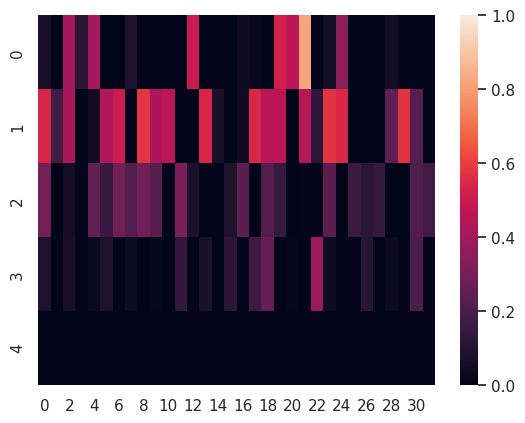

In [16]:
sns.set()
ax = sns.heatmap(n, vmin=0, vmax=1)
plt.show()

## Проза

In [17]:
!wget https://github.com/d-yacenko/data/raw/main/war_and_peace.txt
!wget https://github.com/d-yacenko/data/raw/main/author_quotes.txt

--2024-05-03 20:21:44--  https://github.com/d-yacenko/data/raw/main/war_and_peace.txt
Распознаётся github.com (github.com)… 140.82.121.4
Подключение к github.com (github.com)|140.82.121.4|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://raw.githubusercontent.com/d-yacenko/data/main/war_and_peace.txt [переход]
--2024-05-03 20:21:44--  https://raw.githubusercontent.com/d-yacenko/data/main/war_and_peace.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 1398793 (1,3M) [text/plain]
Сохранение в: «war_and_peace.txt.6»

war_and_peace.txt.6 100%[===================>]   1,33M  4,21MB/s    за 0,3s    

2024-05-03 20:21:45 (4,21 MB/s) - «war_and_peace.txt.6» сохранён [1398793/1398793]

--2024-05-03 20:21:45

In [3]:
with open('war_and_peace.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]

In [4]:
tokens = list(set(''.join(quotes)))
tokens.sort()
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)

In [5]:
num_tokens

143

In [6]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [7]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [8]:
print('\n'.join(quotes[::2000]))
print(to_matrix(quotes[::2000], token_to_id))

                           Лев Николаевич Толстой
   - Экое золото у меня этот Митенька, - прибавил граф улыбаясь, когда молодой
 (сноска 44) Расскажите нам это, виконт,
 подбирая кожу над левым глазом, - malgre la haute estime que je professe pour
   - Как однако странно, - сказала Вера, выбрав общую минуту молчания, - что
 обращаясь в его сторону. - Для чего вы, неверующий в истины света и не видящий
   "Нет, теперь уже не упущу случая, как после Аустерлица, думал он, ожидая всякую
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0  91 115 112   0  93 118 120 124 121
  110 115 112 118 133   0  98 124 121 127 128 124 119   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  10   0 107 120 124 115   0 117 124 121 124 128 124   0 129
    0 122 115 123 141   0 139 128 124 128   0  92 118 128 115 123 138 120
  110   9   0  10   0 12

## RNN

![rnn](https://raw.githubusercontent.com/sic-rus-ai/stepik-dl-nlp/9398e845a1e57415f746dca77c0b557602a4902b//img/rnn.png)

In [9]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [10]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=15, rnn_num_units=1024):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, logits
        # return h_next, F.log_softmax(logits, dim=-1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [11]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size).to(device)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
       
    return torch.stack(logprobs, dim=1)

In [15]:
char_rnn = CharRNNCell().to(device)
opt = torch.optim.Adam(char_rnn.parameters())
history = []
loss_func = nn.CrossEntropyLoss()

In [16]:
MAX_LENGTH = max(map(len, quotes))

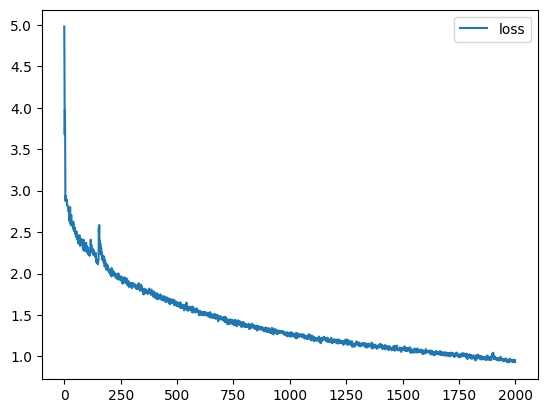

In [14]:
for i in range(2000):
    batch_ix = to_matrix(sample(quotes, BATCH_SIZE), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    # loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    loss = loss_func(
    predictions_logp.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.cpu().data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [20]:
# torch.save(char_rnn.state_dict(), "rnn.pt")
char_rnn.load_state_dict(torch.load("rnn.pt"))

<All keys matched successfully>

In [18]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=0.3):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1).to(device)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i].to(device), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1].to(device), hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).cpu().data.numpy()[0]       
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [19]:
for _ in range(10):
    print(generate_sample(char_rnn,seed_phrase=' Князь ',temperature=0.4))

 Князь Андрей подъехал к крыльцо и не понимаю, - сказал он, - когда он поднялся и вел
 Князь Андрей встал и подошел к окну. Но которой после                               
 Князь Андрей посел стола в то время как он стал                                     
 Князь Андрей встретившись по пять история с домой. В одно посла в деле, и в комнате 
 Князь Андрей подал ему                                                              
 Князь Андрей в                                                                      
 Князь Андрей почувствовал, что все может быть не находил с                          
 Князь Андрей не отвечая на последние службы обедать к ним исполните его по нем...   
 Князь Андрей встретившись к                                                         
 Князь Андрей подъехал к кресло, стараясь по всему солдаты, то на котором он не знал,


## LSTM

![lstm](https://i.stack.imgur.com/bVXaT.png)

source: https://datascience.stackexchange.com/questions/82808/whats-the-difference-between-the-cell-and-hidden-state-in-lstm

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
class LSTMCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    
    def __init__(self, num_tokens=len(tokens), embedding_size=15, lstm_num_units=1024):    
        super(self.__class__,self).__init__()
        self.num_units = lstm_num_units  
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.fc1 = nn.Linear(embedding_size + lstm_num_units, lstm_num_units)
        self.fc2 = nn.Linear(embedding_size + lstm_num_units, lstm_num_units)
        self.fc3 = nn.Linear(embedding_size + lstm_num_units, lstm_num_units)
        self.fc4 = nn.Linear(embedding_size + lstm_num_units, lstm_num_units)
      
        self.lstm_to_logits = nn.Linear(lstm_num_units, num_tokens)
    def forward(self, x, h_prev,c_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous lstm hidden states, variable containing matrix [batch, lstm_num_units] of float32
        """
        # x=torch.tensor(x, dtype=torch.int64)
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        f=F.sigmoid(self.fc1(x_and_h))
        i=F.sigmoid(self.fc2(x_and_h))
        c=F.tanh(self.fc3(x_and_h))
        o=F.sigmoid(self.fc4(x_and_h))
        c_next = c_prev*f+i*c
        h_next = F.tanh(c_next)*o 
        logits = self.lstm_to_logits(h_next)
 
        assert h_next.size() == h_prev.size()
        assert c_next.size() == c_prev.size()
        
        #compute logits for next character probs
        logits = self.lstm_to_logits(h_next)
        
        return h_next,c_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return lstm state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units,dtype=torch.float32)),Variable(torch.zeros(batch_size, self.num_units,dtype=torch.float32))

In [11]:
def lstm_loop(lstm, batch_index):
    """
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state,cell_state = lstm.initial_state(batch_size)
    hid_state=hid_state.to(device)
    cell_state=cell_state.to(device)
    logprobs = []
    
    for x_t in batch_index.transpose(0,1):
        hid_state, cell_state, logp_next = lstm(x_t, hid_state, cell_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [12]:
char_lstm = LSTMCell().to(device)
opt = torch.optim.Adam(char_lstm.parameters())
history = []

In [13]:
MAX_LENGTH = max(map(len, quotes))

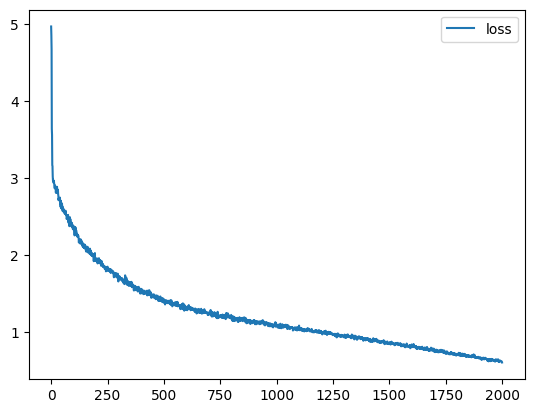

In [26]:
for i in range(2000):
    batch_ix = to_matrix(sample(quotes, BATCH_SIZE), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logp_seq = lstm_loop(char_lstm, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.cpu().data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "LSTM didn't converge."

In [14]:
# torch.save(char_lstm.state_dict(), "lstm.pt")
char_lstm.load_state_dict(torch.load("lstm.pt"))

<All keys matched successfully>

In [15]:
def generate_sample_lstm(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=0.3):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state, cell_state = char_rnn.initial_state(batch_size=1)
    hid_state=hid_state.to(device)
    cell_state=cell_state.to(device)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state,cell_state, _ = char_rnn(x_sequence[:, i].to(device), hid_state, cell_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, cell_state,logp_next = char_rnn(x_sequence[:, -1].to(device), hid_state, cell_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).cpu().data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [16]:
for _ in range(10):
    print(generate_sample_lstm(char_lstm,seed_phrase=' К',temperature=0.4))

 Кутузов старался против полковой командир, подскакивая глаза и сам с своею          
 Кутузова с восторг, по солдатским гостьми стариками, поднимая причител мертвого     
 Каристой видел и окружавших его и поправился с ней.                                 
 Кутузов послал своих гусар, подошел к нему и волная привычка. Как только            
 Князь Андрей подошел к мене удивленной ноги в руки последний девушке и близки       
 Когда выше бы и добрые и близко стояли на помощь к обедумку.                        
 Княжна Марья не могла уполне спроке даже со всею армии и получил об этому.          
 Кутузов отступил на горе.                                                           
 Кутузов обестил мужик и замерший генерал, и в этом доме стороны стояла и            
 Кутузов отвернулся, она с своими разливавшими из старшего после которой сидел       
